In [1]:
#%pip install scikit-learn
#%pip install matplotlib-venn

In [2]:
import pandas as pd

import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer, pipeline
from sklearn.metrics import accuracy_score, f1_score
import json
from datasets import load_dataset, Split

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted

C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# rlhf = 'anime'
# rlhf = 'steam' 
rlhf = 'movie'
# rlhf = 'movies-all'
rlhf = 'anime-tags'
rlhf = 'source'

In [4]:
dataset = load_dataset("csv", data_files=f"{rlhf}.csv", split=Split.ALL)

In [5]:
dataset

Dataset({
    features: ['file', 'C', 'C++', 'Rust', 'Go', 'JavaScript', 'TypeScript', 'isComment', 'text'],
    num_rows: 732885
})

In [6]:
if rlhf == 'anime':
    labels = [ 'Comedy', 'Romance', 'Action', 'Horror' ]
elif rlhf == 'steam':
    labels = [ 'RPG', 'Strategy', 'Casual' ]
elif rlhf == 'movie':
    labels = [ 'Action', 'Horror', 'Comedy' ]
elif rlhf == 'anime-tags':
    labels = [ 'Isekai', 'Seinen', 'Shounen' ]
elif rlhf == 'source':
    labels = [ 'C', 'C++', 'Rust', 'Go', 'JavaScript', 'TypeScript' ]

id2label={i:l for i,l in enumerate(labels)}
label2id={l:i for i,l in enumerate(labels)}

In [7]:
data = []
empties = 0
big = {'size': 0, 'i': 0}
small = {'size': 1_000_000_000, 'i': 0}
for i, d in enumerate(dataset):
    # if not d['isAdult']:
    #     continue
    # this caused a throw in tokenizer
    text = 'text' # 'description'

    if d[text] is None:
        empties += 1
        continue

    # this isnt right or soemthing
    if len(d[text]) > big['size']:
        big = {'size': len(d[text]), 'i': i}
    if len(d[text]) < small['size']:
        small = {'size': len(d[text]), 'i': i}

    # i think this makes it where ones not in labels dont get added
    for label in labels:
        if d[label]:
            data.append({ 'category': label, 'text': d[text], 'label': label2id[label] })

df_data = pd.DataFrame(data)
print(empties)
display(df_data)
print(   df_data.category.value_counts()   )

print('max', big)
print('min', small)

# TODO get equal amount of all labels
df_sample = df_data.groupby('category').sample(n=4000) # frac=1.0
display(df_sample)
# must be randomized, otherwise val is all one language
df_data = df_sample.sample(frac=1.0) # return all in random order


0


,category,text,label
0,C,/*\n==========================================...,0
1,C,MERCHANTABILITY or FITNESS FOR A PARTICULAR PU...,0
2,C,#define ITEM_TYPE_RADIOBUTTON 2 // t...,0
3,C,#define ITEM_TYPE_SLIDER 10 // m...,0
4,C,#define ITEM_TEXTSTYLE_BLINK 1 // f...,0
...,...,...,...
732880,TypeScript,\texport interface IssueUriRequestHandler {\n\...,5
732881,TypeScript,\t}\n\n\texport namespace env {\n\t\t/**\n\t\t...,5
732882,TypeScript,\t\t *\n\t\t * @param handler the issue uri re...,5
732883,TypeScript,/*--------------------------------------------...,5


category
Go            331268
TypeScript    129522
C             108826
Rust          108458
C++            50292
JavaScript      4519
Name: count, dtype: int64
max {'size': 1377567, 'i': 677728}
min {'size': 2, 'i': 35}


,category,text,label
51700,C,\tnew[1] = (lp1[1] + lp2[1]) >> 1;\n\tnew[5] =...,0
9486,C,"\t\tGL_DECAL, 0 },\n#endif\n\t{ -1 }\n};\n\n/*...",0
68884,C,"\t\t\t\t\tSetSystemPaletteUse(hdc, SYSPAL_NOST...",0
86568,C,"\tvoid\t\t\tInitRead( const byte *data, int le...",0
7629,C,\t\t\t\t\tv1 = grid1->verts[grid1->width * k +...,0
...,...,...,...
705850,TypeScript,\t\t\t\t// directories. If we've resolved a dr...,5
703013,TypeScript,"\t\trenderer.renderElement(nodeCopy, stickyNod...",5
716782,TypeScript,/*--------------------------------------------...,5
627393,TypeScript,\t\tconst useCustomTitleStyle = !hasNativeTitl...,5


In [8]:
def conv(mask):
    return format(mask, f'#0{len(labels)+2}b')[2:]

# dont do zero
# should be l!, but this is fine
total = 0
sizes = { conv(i): 0 for i in range(1, 2**len(labels)) }
for d in dataset:
    mask = 0
    for i, l in enumerate(labels):
        if d[l] == True:
            mask |= 2**i
    if mask != 0:
        sizes[conv(mask)] += 1
    total+=1
print(sizes, total)

{'000001': 108826, '000010': 50292, '000011': 0, '000100': 108458, '000101': 0, '000110': 0, '000111': 0, '001000': 331268, '001001': 0, '001010': 0, '001011': 0, '001100': 0, '001101': 0, '001110': 0, '001111': 0, '010000': 4519, '010001': 0, '010010': 0, '010011': 0, '010100': 0, '010101': 0, '010110': 0, '010111': 0, '011000': 0, '011001': 0, '011010': 0, '011011': 0, '011100': 0, '011101': 0, '011110': 0, '011111': 0, '100000': 129522, '100001': 0, '100010': 0, '100011': 0, '100100': 0, '100101': 0, '100110': 0, '100111': 0, '101000': 0, '101001': 0, '101010': 0, '101011': 0, '101100': 0, '101101': 0, '101110': 0, '101111': 0, '110000': 0, '110001': 0, '110010': 0, '110011': 0, '110100': 0, '110101': 0, '110110': 0, '110111': 0, '111000': 0, '111001': 0, '111010': 0, '111011': 0, '111100': 0, '111101': 0, '111110': 0, '111111': 0} 732885


C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\matplotlib_venn\_venn3.py:47: UserWarning: All circles have zero area
  warnings.warn("All circles have zero area")


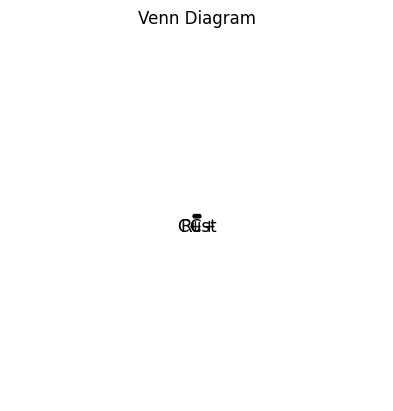

In [9]:
# sizes = { '100': 20, '010': 25, '001': 30, '110': 35, '101': 40, '011': 45, '111': 50 }
# 001 010 011 100 101 110 111
venn = venn3(subsets = sizes, set_labels = labels)
venn_circles = venn3_circles(subsets = sizes, linestyle = '--')

plt.title('Venn Diagram')
plt.show()

In [10]:
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels), id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
SIZE = df_data.shape[0]

train_texts= list(df_data.text[:SIZE//2])
val_texts=   list(df_data.text[SIZE//2:(3*SIZE)//4 ])
test_texts=  list(df_data.text[(3*SIZE)//4:])

train_labels= list(df_data.label[:SIZE//2])
val_labels=   list(df_data.label[SIZE//2:(3*SIZE)//4])
test_labels=  list(df_data.label[(3*SIZE)//4:])

print(   len(train_texts), len(val_texts), len(test_texts)   )

12000 6000 6000


In [12]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings   = tokenizer(val_texts,   truncation=True, padding=True)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True)

In [13]:
class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [14]:
train_dataset = MyDataset(train_encodings, train_labels)
val_dataset   = MyDataset(val_encodings,   val_labels)
test_dataset  = MyDataset(test_encodings,  test_labels)

In [15]:
def compute_metrics(pred): 
    labels = pred.label_ids 
    preds  = pred.predictions.argmax(-1) 
    f1  = f1_score(labels, preds, average='macro') 
    acc = accuracy_score(labels, preds) 
    return {
        'Accuracy': acc,
        'F1': f1
    }

In [16]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir=f'{rlhf}-model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=3,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size  = 8,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="epoch",
    ## fp16=True
    #load_best_model_at_end=True
)

In [17]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics= compute_metrics
)

In [18]:
res_train = trainer.train()
print(res_train)

Step,Training Loss,Validation Loss,Accuracy,F1
50,1.787700,1.750633,0.243833,0.189840
100,1.716200,1.510060,0.390167,0.340442
150,1.425800,1.262591,0.491333,0.456040
200,1.189200,1.105274,0.569167,0.500492
250,1.030000,0.886222,0.629500,0.588667
300,0.990600,0.784408,0.668000,0.641038
350,0.816700,0.834847,0.638833,0.603337
400,0.829100,0.760510,0.682833,0.672895
450,0.785100,0.826734,0.652667,0.622937
500,0.785100,0.808068,0.669667,0.658720


Checkpoint destination directory source-model\checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=4500, training_loss=0.4488272559907701, metrics={'train_runtime': 5887.9743, 'train_samples_per_second': 6.114, 'train_steps_per_second': 0.764, 'total_flos': 9472338173952000.0, 'train_loss': 0.4488272559907701, 'epoch': 3.0})


In [19]:
trainer.save_model(f'{rlhf}-model/final-trainer')
tokenizer.save_pretrained(f'{rlhf}-model/final-tokenizer')

('source-model/final-tokenizer\\tokenizer_config.json',
 'source-model/final-tokenizer\\special_tokens_map.json',
 'source-model/final-tokenizer\\vocab.txt',
 'source-model/final-tokenizer\\added_tokens.json',
 'source-model/final-tokenizer\\tokenizer.json')

In [20]:
q = [trainer.evaluate(eval_dataset=data) for data in [train_dataset, val_dataset, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_runtime,eval_samples_per_second
train,0.119102,0.958833,0.958984,109.1967,109.893
val,0.524076,0.863833,0.863075,55.7533,107.617
test,0.509881,0.869500,0.868687,55.8908,107.352


In [21]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return probs, probs.argmax(),model.config.id2label[probs.argmax().item()]

In [22]:
text = ""
print(predict(text))

(tensor([[0.1998, 0.0710, 0.1229, 0.3182, 0.1766, 0.1116]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), tensor(3, device='cuda:0'), 'Go')


## Predict

In [23]:
model = BertForSequenceClassification.from_pretrained(f"{rlhf}-model/final-trainer")
tokenizer= BertTokenizerFast.from_pretrained(f"{rlhf}-model/final-tokenizer")

sent_kwargs = {
         "return_all_scores": True, 
         "function_to_apply": "none", 
         "batch_size": 16
}
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, **sent_kwargs)

C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [24]:
if rlhf == 'anime':
    text = "For hearing-impaired university student Yuki Itose, silence has been a natural part \
of life since birth. Her world is small and isolated; she commutes to campus, interacts with \
her best friend Rin Fujishiro, and communicates through writing and text messages—a lifestyle \
that offers little to no change. One day, during her commute, Yuki meets fellow student \
Itsuomi Nagi, a multilingual travel enthusiast and friend of Rin. When Itsuomi learns of \
Yuki's condition, he takes it in stride, moving Yuki's heart. From this one simple \
gesture, Yuki and Itsuomi's lives start changing day by day as they let each other into their own worlds."
elif rlhf == 'steam':
    # voices of the void
    # https://mrdrnose.itch.io/votv
    text = "You work as a scientist in the isolated research lab in the mountains of Switzerland. \
Your task is to gather signals from space, analyze them, process them and sell them to get points. \
You can get regular signals and objects like dwarf planets and stars, or you can get something \
\"unusual\" or \"strange\" The game has 40+ days and events, 150+ possible signals, \
some easter eggs and secrets."
elif rlhf == 'movie' or rlhf == 'movies-all':
    text = "A Street Kid trying to survive in a technology and body modification-obsessed \
city of the future. Having everything to lose, he chooses to stay alive by becoming an Edgerunner, \
a Mercenary outlaw also known as a Cyberpunk."
elif rlhf == 'anime-tags':
    text = "Tomokui Kanata has been re-incarnated in the weakest goblin, named Goburou, \
after having undergone an unfortunate death. However Goburou has retained his previous life's \
memories, an unusual evolution, as well as becoming strong enough to gain status boosts from eating. \
In this alternate world of survival of the fittest, events unfold with competent subordinates \
and comrades, delightful case of the tail-wagging dog..."
elif rlhf == 'source':
    text = 'func (m model) Update(msg tea.Msg) (tea.Model, tea.Cmd) {\
	switch msg := msg.(type) {\
	case tea.KeyMsg:\
		// Increment the tag on the model...\
		m.tag++\
		return m, tea.Tick(debounceDuration, func(_ time.Time) tea.Msg {\
			// ...and include a copy of that tag value in the message.\
			return exitMsg(m.tag)\
		})\
	case exitMsg:\
		// If the tag in the message doesnt match the tag on the model then we\
		// know that this message was not the last one sent and another is on\
		// the way. If thats the case we know, we can ignore this message.\
		// Otherwise, the debounce timeout has passed and this message is a\
		// valid debounced one.\
		if int(msg) == m.tag {\
			return m, tea.Quit\
		}\
	}\
\
	return m, nil\
}'

print(text)
r1 = nlp(text)
# 28: 'Action', 53: 'Horror', 35: 'Comedy'
print(json.dumps(r1, indent='\t'))

func (m model) Update(msg tea.Msg) (tea.Model, tea.Cmd) {	switch msg := msg.(type) {	case tea.KeyMsg:		// Increment the tag on the model...		m.tag++		return m, tea.Tick(debounceDuration, func(_ time.Time) tea.Msg {			// ...and include a copy of that tag value in the message.			return exitMsg(m.tag)		})	case exitMsg:		// If the tag in the message doesnt match the tag on the model then we		// know that this message was not the last one sent and another is on		// the way. If thats the case we know, we can ignore this message.		// Otherwise, the debounce timeout has passed and this message is a		// valid debounced one.		if int(msg) == m.tag {			return m, tea.Quit		}	}	return m, nil}
[
	[
		{
			"label": "C",
			"score": -0.8578859567642212
		},
		{
			"label": "C++",
			"score": -2.3334949016571045
		},
		{
			"label": "Rust",
			"score": -0.2530737519264221
		},
		{
			"label": "Go",
			"score": 7.785497665405273
		},
		{
			"label": "JavaScript",
			"score": -1.9600989818572998
		},
		{
